In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRegressor

from scipy.stats import randint, uniform

In [2]:
raw_data=pd.read_csv("car_insurance_claim.csv")

In [3]:
pd.set_option('display.max_columns', None)
raw_data.head(5)

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


In [4]:
df=raw_data.copy()

In [5]:
col_names = {
    'KIDSDRIV': 'num_young_drivers',
    'BIRTH': 'date_of_birth',
    'AGE': 'age',
    'HOMEKIDS': 'num_of_children',
    'YOJ': 'years_job_held_for',
    'INCOME': 'income',
    'PARENT1': 'single_parent',
    'HOME_VAL': 'value_of_home',
    'MSTATUS': 'married',
    'GENDER': 'gender',
    'EDUCATION': 'highest_education',
    'OCCUPATION': 'occupation',
    'TRAVTIME': 'commute_dist',
    'CAR_USE': 'type_of_use',
    'BLUEBOOK': 'vehicle_value',
    'TIF': 'policy_tenure',
    'CAR_TYPE': 'vehicle_type',
    'RED_CAR': 'red_vehicle',
    'OLDCLAIM': '5_year_total_claims_value',
    'CLM_FREQ': '5_year_num_of_claims',
    'REVOKED': 'licence_revoked',
    'MVR_PTS': 'license_points',
    'CLM_AMT': 'new_claim_value',
    'CAR_AGE': 'vehicle_age',
    'CLAIM_FLAG': 'is_claim',
    'URBANICITY': 'address_type'
}
df.rename(columns=col_names, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         10302 non-null  int64  
 1   num_young_drivers          10302 non-null  int64  
 2   date_of_birth              10302 non-null  object 
 3   age                        10295 non-null  float64
 4   num_of_children            10302 non-null  int64  
 5   years_job_held_for         9754 non-null   float64
 6   income                     9732 non-null   object 
 7   single_parent              10302 non-null  object 
 8   value_of_home              9727 non-null   object 
 9   married                    10302 non-null  object 
 10  gender                     10302 non-null  object 
 11  highest_education          10302 non-null  object 
 12  occupation                 9637 non-null   object 
 13  commute_dist               10302 non-null  int

In [7]:
df.duplicated().sum()

1

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
currency_cols = ['income', 'value_of_home', 'vehicle_value', '5_year_total_claims_value', 'new_claim_value']
for col in currency_cols:
    df[col]=df[col].replace({'\$':'',',':''},regex=True).astype('Int64')


In [10]:
z_prefix_cols = ['married', 'gender', 'highest_education', 'occupation', 'vehicle_type', 'address_type']
for col in z_prefix_cols:
    df[col] = df[col].replace('[z_]', '', regex=True)

In [11]:
df.drop(['ID','date_of_birth'],axis=1,inplace=True)

In [12]:
df.head(5)

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


CHECKING FOR DATA INCONSISTENCY.
IF NEW CLAIM VALUE>0 THEN IS CLAIM SHOULD NOT BE FALSE.

In [16]:
check = (df['new_claim_value'] > 0) & (df['is_claim'] == 0)
df[check]

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type


<Axes: xlabel='new_claim_value', ylabel='Count'>

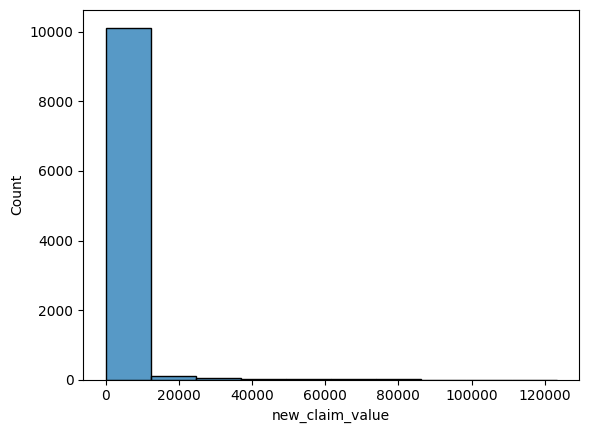

In [21]:
sns.histplot(df['new_claim_value'], bins=10)

In [28]:
# Define bins
bins = [0.0, 5000, 10_000, 15_000, 20_000, 25_000, 30_000, 35_000, 40_000, 45_000, 50_000, np.inf]
# Define bin labels
labels = np.arange(1, 12)

# Apply the bins using cut
df['claim_value_cat'] = pd.cut(df['new_claim_value'], bins = bins, labels= labels, include_lowest=True)

In [29]:
df['claim_value_cat'].value_counts()

claim_value_cat
1     9316
2      789
4       48
3       45
5       27
11      19
6       18
7       14
8       10
9        8
10       7
Name: count, dtype: int64

<Axes: ylabel='claim_value_cat'>

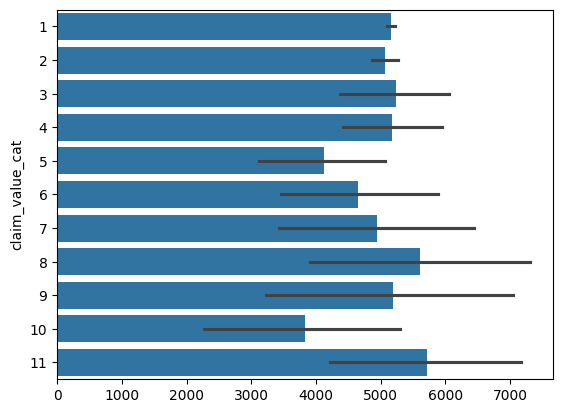

In [30]:
sns.barplot(df['claim_value_cat'])

In [33]:
X=df.loc[:, ~df.columns.isin( ['is_claim','new_claim_value'])]
y=df['is_claim']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
df_copy=df.copy()

In [38]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
binary_cols = ['single_parent', 'married', 'gender', 'red_vehicle', 'licence_revoked']
le=LabelEncoder()
for col in binary_cols:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    df_copy[col] = le.fit_transform(df_copy[col])

In [39]:
df_copy.head(5)

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type,claim_value_cat
0,0,60.0,0,11.0,67349,0,0,0,1,PhD,Professional,14,Private,14230,11,Minivan,1,4461,2,0,3,0,18.0,0,Highly Urban/ Urban,1
1,0,43.0,0,11.0,91449,0,257252,0,1,High School,Blue Collar,22,Commercial,14940,1,Minivan,1,0,0,0,0,0,1.0,0,Highly Urban/ Urban,1
2,0,48.0,0,11.0,52881,0,0,0,1,Bachelors,Manager,26,Private,21970,1,Van,1,0,0,0,2,0,10.0,0,Highly Urban/ Urban,1
3,0,35.0,1,10.0,16039,0,124191,1,0,High School,Clerical,5,Private,4010,4,SUV,0,38690,2,0,3,0,10.0,0,Highly Urban/ Urban,1
4,0,51.0,0,14.0,<NA>,0,306251,1,1,<High School,Blue Collar,32,Private,15440,7,Minivan,1,0,0,0,0,0,6.0,0,Highly Urban/ Urban,1


In [41]:
df_copy.corr(numeric_only=True).sort_values(by='is_claim',ascending=False)

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,commute_dist,vehicle_value,policy_tenure,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim
is_claim,0.108404,-0.107013,0.123015,-0.066216,-0.142552,0.158436,-0.185355,-0.129687,-0.021947,0.053268,-0.103295,-0.081293,-0.007297,0.142895,0.222586,0.155970,0.222449,0.530551,-0.109909,1.000000
new_claim_value,0.068273,-0.049056,0.068628,-0.026771,-0.057665,0.096219,-0.091967,-0.083826,0.003421,0.031262,-0.002446,-0.046553,0.004073,0.076522,0.122186,0.072471,0.133547,1.000000,-0.066108,0.530551
5_year_num_of_claims,0.038930,-0.037688,0.038619,-0.023476,-0.049175,0.061589,-0.093809,-0.070509,0.014075,0.008255,-0.042138,-0.017450,0.023504,0.494453,1.000000,0.055486,0.401381,0.122186,-0.018998,0.222586
license_points,0.048400,-0.075788,0.064248,-0.041526,-0.063445,0.070114,-0.092409,-0.050839,-0.011029,0.009673,-0.044828,-0.031247,0.002758,0.262006,0.401381,0.050113,1.000000,0.133547,-0.034007,0.222449
single_parent,0.200147,-0.311362,0.448707,-0.039196,-0.067137,1.000000,-0.250356,-0.474832,-0.068858,-0.015821,-0.049516,0.009004,-0.044446,0.039296,0.061589,0.050663,0.070114,0.096219,-0.066332,0.158436
licence_revoked,0.033628,-0.045076,0.044159,-0.009921,-0.022909,0.050663,-0.044765,-0.040749,-0.011411,-0.002774,-0.028943,-0.031891,-0.009271,0.418200,0.055486,1.000000,0.050113,0.072471,-0.020175,0.155970
5_year_total_claims_value,0.023872,-0.033409,0.029728,-0.005036,-0.039316,0.039296,-0.059772,-0.044582,-0.004107,-0.013819,-0.030731,-0.015569,0.006519,1.000000,0.494453,0.418200,0.262006,0.076522,-0.019226,0.142895
num_of_children,0.463644,-0.447848,1.000000,0.077768,-0.160193,0.448707,-0.107442,0.046022,-0.113344,-0.000739,-0.108579,0.007444,-0.068028,0.029728,0.038619,0.044159,0.064248,0.068628,-0.159110,0.123015
num_young_drivers,1.000000,-0.078451,0.463644,0.043002,-0.043196,0.200147,-0.015424,0.041683,-0.039679,0.012198,-0.028512,-0.005865,-0.040463,0.023872,0.038930,0.033628,0.048400,0.068273,-0.059678,0.108404
commute_dist,0.012198,-0.001587,-0.000739,-0.017128,-0.051835,-0.015821,-0.035120,0.006032,-0.010510,1.000000,-0.022539,-0.013357,0.003521,-0.013819,0.008255,-0.002774,0.009673,0.031262,-0.033330,0.053268
